In [2]:
import gym
import numpy as np
import time
import os
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [251]:
class QControl:
    def __init__(self, nS, nA, terminal=list(range(37,48)), eps=None, initializer=None):
        self.Q = np.random.normal(0.5,0.25, (nS, nA) )

        if initializer!=None:
            self.Q = initializer(nS, nA)
            
        
        for i in terminal:
            self.Q[i] = np.array([0, 0, 0, 0])
        
        self.pi = np.random.randint(0, 4, (16, ), dtype=np.int8)
        self.alpha = 0.2
        self.gamma = 0.9
        self.epsilon = eps
        self.last_action = 0
    
    def policy(self, state, eps=None):
        
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.2
        
        
        if np.random.random() >= eps:
            return np.argmax(self.Q[state])
        else:
            return np.random.randint(0, 4)
        
    def learn(self, s, env, step_size, eps=None):
        if eps == None:
            if self.epsilon != None:
                eps = self.epsilon
            else:
                eps = 0.2
        a = self.policy(s, eps=eps)
        s_, r, done, probs = env.step(a)
        
        self.Q[s,a] = self.Q[s,a] + step_size*(r + np.max(self.Q[s_]) - self.Q[s, a]   )
        
        self.last_action = a
        
        return s_, r, done, probs
    
    def plan(self, s, model, step_size,a,  eps=None):
        
                
        r, s_ = model[s, a]
        self.Q[s,a] = self.Q[s,a] + step_size*(r + np.max(self.Q[s_]) - self.Q[s, a]   )
        self.last_action = a
        return s_, r, False, _
    


# Dyna Q
Dyna Q integrates learning and planning like all the dyna methods do...

Direct RL is taking experience and doing learning (like Q Learning)
Indirect RL is taking experience to improve the model and then do planning on it(Q Planning) 


In [270]:
def dyna(QControl, env, planning_steps, n_episodes,  step_size=0.5):
    
    q_control = QControl(env.nS, env.nA, eps=0.2)
    model = {}
    
    observed_states = set({})
    observed_actions = {s:set() for s in range(env.nS)}
    curr_s = env.reset()
    rewards = []
    Rs= 0
    steps = []
    for i in range(n_episodes):
        
        done = False
        Rs = 0
        steps_this_episode = 0
        curr_s = env.reset()
        while not done:
        
            s_, r, done, _ = q_control.learn(curr_s, env, step_size)
            a = q_control.last_action

            
            model[curr_s, a] = [r, s_]


            observed_actions[curr_s].add(a)
            observed_states.add(curr_s)
            curr_s = s_
            Rs+=r
            steps_this_episode += 1
                



            for n in range(planning_steps):
                
                s = np.random.choice(list(observed_states))
                a = np.random.choice(list(observed_actions[s]))

                

                q_control.plan(s, model, step_size, a)

        rewards.append(Rs)
        steps.append(steps_this_episode)
    return rewards, steps, q_control

In [281]:
rs0, steps0, qcontrol = dyna(QControl, env, 0, 50, step_size=0.1)
rs1, steps1, qcontrol = dyna(QControl, env, 1, 50, step_size=0.1)
rs2, steps2, qcontrol = dyna(QControl, env, 5, 50, step_size=0.1)
rs3, steps3, qcontrol = dyna(QControl, env, 15, 50, step_size=0.1)

In [282]:
def get_moving_avg(arr, window_size=10):
    M = [arr[0]]
    for i in range(1, len(arr)-window_size):
        M.append(np.mean(arr[i:min(i+window_size, len(arr)-1)]))
    return M
    

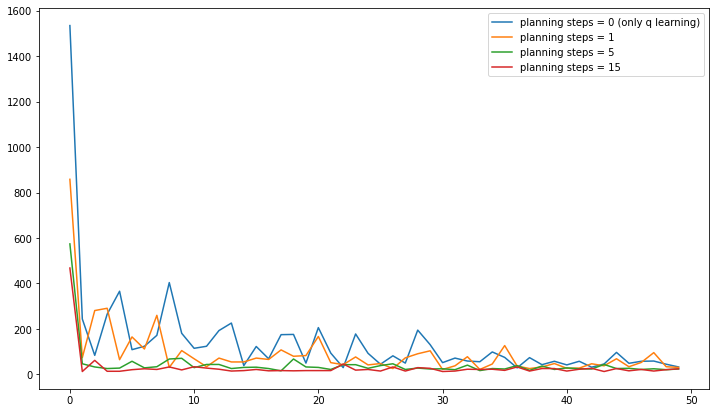

In [284]:
plt.figure(figsize=(12,7))
plt.plot(steps0, label="planning steps = 0 (only q learning)")
plt.plot(steps1, label="planning steps = 1")
plt.plot(steps2, label="planning steps = 5")
plt.plot(steps3, label="planning steps = 15")
plt.legend()


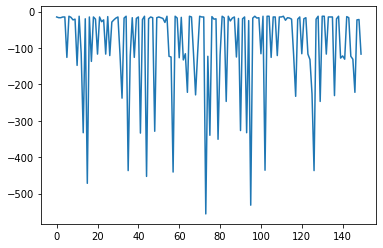

In [264]:
plt.plot(rs1)

In [246]:
def demo_policy(control, limit=30):
    env.reset()
    out = env.render(mode="ansi")
    done = False
    s = env.reset()
    i = 0
    while not done:
        
        s_, r, done, prop = env.step(np.argmax(control.Q[s]))
        time.sleep(0.5)
        clear_output()
        print(env.render())
        s = s_
        i+=1
        if i >= limit:
            done = True
    

In [280]:
demo_policy(qcontrol, limit=250)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

None


In [88]:
env = gym.make('CliffWalking-v0')

In [6]:
env.step(0)

(24, -1, False, {'prob': 1.0})

In [7]:
env.metadata

{'render.modes': ['human', 'ansi']}

In [132]:
model = np.random.random((env.nS, env.nA, 2)).astype(np.dtype([('x', float), ('y', int)]))

model[:,:,0] = np.random.randint(0, env.nS,(env.nS, env.nA) )
model[:,:,1] = np.random.random((env.nS, env.nA) )

In [133]:
model[:,:,1]

array([[(0.06015012, 0), (0.09751299, 0), (0.61436325, 0),
        (0.88016994, 0)],
       [(0.16764226, 0), (0.2064565 , 0), (0.61650511, 0),
        (0.05782926, 0)],
       [(0.3668788 , 0), (0.59866257, 0), (0.96892208, 0),
        (0.53348143, 0)],
       [(0.8313402 , 0), (0.72333717, 0), (0.1981491 , 0),
        (0.68838324, 0)],
       [(0.96106941, 0), (0.88414592, 0), (0.95019117, 0),
        (0.9903116 , 0)],
       [(0.3769527 , 0), (0.20041199, 0), (0.02562082, 0),
        (0.52444962, 0)],
       [(0.71052155, 0), (0.66384095, 0), (0.14666606, 0),
        (0.09413269, 0)],
       [(0.3629262 , 0), (0.52927297, 0), (0.01436678, 0),
        (0.91878062, 0)],
       [(0.50874789, 0), (0.52303235, 0), (0.91661161, 0),
        (0.48394367, 0)],
       [(0.98221695, 0), (0.06724482, 0), (0.11726499, 0),
        (0.74635937, 0)],
       [(0.3373713 , 0), (0.20045801, 0), (0.38962178, 0),
        (0.34751078, 0)],
       [(0.15647284, 0), (0.19873056, 0), (0.57174067, 0),
      

In [50]:
s = set()

In [52]:
s.add(23)

In [60]:
np.random.choice(list(s))

23

In [117]:
env.step(0)

(12, -1, False, {'prob': 1.0})

In [131]:
int(np.ones((env.nS, env.nA, 2)))

TypeError: only size-1 arrays can be converted to Python scalars

In [288]:
env.observation_space

Discrete(48)